# 1. Setup

## 1.1. Importing and installing the necessary libraries


In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install rouge_score

In [ ]:
# Importing necessary librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import io
import pickle 
import datasets
from datasets import load_metric
import seaborn as sns
import tensorflow as tf
import torch
from transformers import BertTokenizer
import keras
from keras import layers
from keras import backend as K
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from google.colab import drive


## 1.2. Importing personal drive to file in order to later load the data and the saved fine tuned model

In [ ]:
# Mount Google Drive to this Notebook instance.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.3. Setting the GPU for training the model 


In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## 2. Loading the training and testing datasets, and the main df to later retrieve the reference summaries

In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/Data/train_dataset.csv') #this will be used to train the model
test_dataset = pd.read_csv('/content/drive/MyDrive/Data/test_dataset.csv') #this will be used to generate predictions 
df = pd.read_pickle('/content/drive/MyDrive/Data/SummaDevDocs_preprocessed.pickle') #this will be used to compute the ROUGE scores of the generated summaries 

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into BERT outputs for the LSTM to be trained on top of it to enhance our summarisation. 

## 3.1. Formatting the data



In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Now computing the longest sentence's length to later pad to that length 
#setting the max length to 0
max_len = 0

#create sentence and label lists from train dataset
sentences = train_dataset.sentence.values
labels = train_dataset.label.values

#for every sentence...
for sent in sentences:

    #tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    #update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

#printing the maximum sentence length. 
print('Max sentence length: ', max_len)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Max sentence length:  210


Now that we have the maximum sentence length, we can pre-process all the sentences as per defined above. 

We use the encode_plus method of huggingface's BERT tokenizer to carry these steps.

## 3.2. Required Formatting

## 3.3. Tokenize Dataset

Using the encode_plus method provided by Huggingface, we tokenise the text, map each token to its input id and pad each sentence for them to match the length of the longest sequence. 

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])


# Convert the lists into numpy arrays.
input_ids = [t.numpy() for t in input_ids]
labels = np.array(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print ('Label:', labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The objective of the Andhra Pradesh Road Sector project for India is to provide better quality, capacity and safe roads to users in a sustainable manner through enhanced institutional capacity of the Andhra Pradesh government in the road sector.
Token IDs: [[  101  1996  7863  1997  1996 14065  7970  2346  4753  2622  2005  2634
   2003  2000  3073  2488  3737  1010  3977  1998  3647  4925  2000  5198
   1999  1037  9084  5450  2083  9412 12148  3977  1997  1996 14065  7970
   2231  1999  1996  2346  4753  1012   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     

## 3.2. Training & Validation Split


In [ ]:
# We must have the input_ids in the right format for the LSTM to read accurately. 
# That is, each sentence must be one array. 
# The current format makes each input_id vector be an array of an array. 

#therefore:
#creating an empty list 
input_id = []

#looping in the first input_ids array
for ids in input_ids: 
  #looping in the final array
  for i in ids:
    #appending to the new list 
    input_id.append(i)

# Creating a train_dataset with the good input_ids format, associating the labels 
train_dataset = pd.DataFrame({'input_ids': input_id,
                             'label' :  labels,
                             })

# Splitting the train_dataset into a main train and a main development set
df_train, df_dev = train_test_split(train_dataset, test_size=0.1, random_state=42)

# Splitting each main train and development sets into an X and a y respectively 
# Converting the data from dataframes to numpy arrays
X_train, y_train = np.vstack(df_train['input_ids'].values), df_train['label'].values
X_dev, y_dev = np.vstack(df_dev['input_ids'].values), df_dev['label'].values

In [ ]:
X_train

array([[  101,  2023,  9530, ...,     0,     0,     0],
       [  101,  2122,  2421, ...,     0,     0,     0],
       [  101,  3445,  4683, ...,     0,     0,     0],
       ...,
       [  101,  1996, 11100, ...,     0,     0,     0],
       [  101,  6922,  2176, ...,     0,     0,     0],
       [  101,  1996,  4746, ...,     0,     0,     0]])

# 4. Train Our Classification Model

## 4.1. Vocabulary size

The LSTM requires an input dimension specification, which should be the size of the vocabulary. 
This is what we compute below. 

In [ ]:
# Create an empty list of all the all_ids which will later be populated with all the ids in every sentence vector. 
all_ids = []

#to do this, we loop a first time into the input_ids
for i in input_ids:
  #a second time
  for j in i: 
    #and a third time to have all individual ids 
    for c in j:
      all_ids.append(c)

# Having all the ids will help us build our vocabulary and therefore know its size
#we create an empty list which will later be populated with all the distinct input_ids representing one same word
vocab = []

#we loop into the all_ids list
for id in all_ids:
  #if the id is not in the list of vocab, we add it to the list 
  if id not in vocab:
    vocab.append(id)

#the size of the vocabulary equals to the maximum value of the vocabulary 
vocab_size = max(vocab)
print('There are {} tokens in the vocab'.format(vocab_size))

There are 30102 tokens in the vocab


## 4.2. Building a fine-tuned stacked LSTM 

Now that we have the necessary information to fine tune our LSTM, we can build the model. 

To that aim, we use the library of keras and the pretrained Sequential model 
To improve its performance, we create a stacked LSTM with 5 layers. 

Additionnally, we add a dense layer with a relu activation and we apply dropout. 
Lastly, we add a single sigmmoid activation dense layer to perform the  classification task. 

Further, we chose adam learning rate for the optimizer, a binay crossentropy loss function and a batch size of 50 for the hyperparameters.

In [ ]:
longest_sequence = 250 
embedding_size = 250

lstm_model = keras.Sequential()  # the keras Sequential class groups a linear stack of layers into a tf.keras.Model

# Add an Embedding layer expecting input vocab, and output dimenstion the size of our embeddings
lstm_model.add(layers.Embedding(input_shape=(longest_sequence,), input_dim=30200, output_dim=64, input_length=longest_sequence,
                                mask_zero=True, trainable=False))


# Create a stacked LSTM with 5 LSTM layers
lstm_model.add(layers.LSTM(256, return_sequences=True))
lstm_model.add(layers.LSTM(256, return_sequences=True))  # and another layer
lstm_model.add(layers.LSTM(128, return_sequences=True))  # and another layer
lstm_model.add(layers.LSTM(64, return_sequences=True))  # and another layer
lstm_model.add(layers.LSTM(32, return_sequences=False))  # and another layer

# Add another Dense layer (with relu activation) and apply dropout
lstm_model.add(keras.layers.Dense(32, activation='relu'))
lstm_model.add(keras.layers.Dropout(rate=0.4))  # we will drop 40% of the input units at random during training

# Add a Dense layer with a single unit and sigmoid activation.
lstm_model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show the model summary
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 64)           1932800   
_________________________________________________________________
lstm (LSTM)                  (None, 250, 256)          328704    
_________________________________________________________________
lstm_1 (LSTM)                (None, 250, 256)          525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 250, 128)          197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 250, 64)           49408     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1

## 4.3. Training our fine-tuned stacked LSTM

We chose to train the model on 50 epochs to start with. We will then adjust the epoch to avoid overfitting the training set. 

In [ ]:
# Set the batch size.  
batch_size = 50  

# Train the model
lstm_trained = lstm_model.fit(X_train, y_train, 
                    batch_size=batch_size, epochs=50,
                    validation_data=(X_dev, y_dev))

Epoch 1/50
449/449 [==============================] - 126s 183ms/step - loss: 0.3978 - accuracy: 0.8767 - val_loss: 0.3583 - val_accuracy: 0.8837
Epoch 2/50
449/449 [==============================] - 76s 169ms/step - loss: 0.3607 - accuracy: 0.8875 - val_loss: 0.3593 - val_accuracy: 0.8837
Epoch 3/50
449/449 [==============================] - 71s 158ms/step - loss: 0.3570 - accuracy: 0.8896 - val_loss: 0.3483 - val_accuracy: 0.8837
Epoch 4/50
449/449 [==============================] - 70s 156ms/step - loss: 0.3500 - accuracy: 0.8920 - val_loss: 0.3549 - val_accuracy: 0.8837
Epoch 5/50
449/449 [==============================] - 68s 153ms/step - loss: 0.3550 - accuracy: 0.8887 - val_loss: 0.3599 - val_accuracy: 0.8837
Epoch 6/50
449/449 [==============================] - 68s 152ms/step - loss: 0.3565 - accuracy: 0.8884 - val_loss: 0.3605 - val_accuracy: 0.8837
Epoch 7/50
449/449 [==============================] - 69s 153ms/step - loss: 0.3500 - accuracy: 0.8912 - val_loss: 0.3595 - val_a

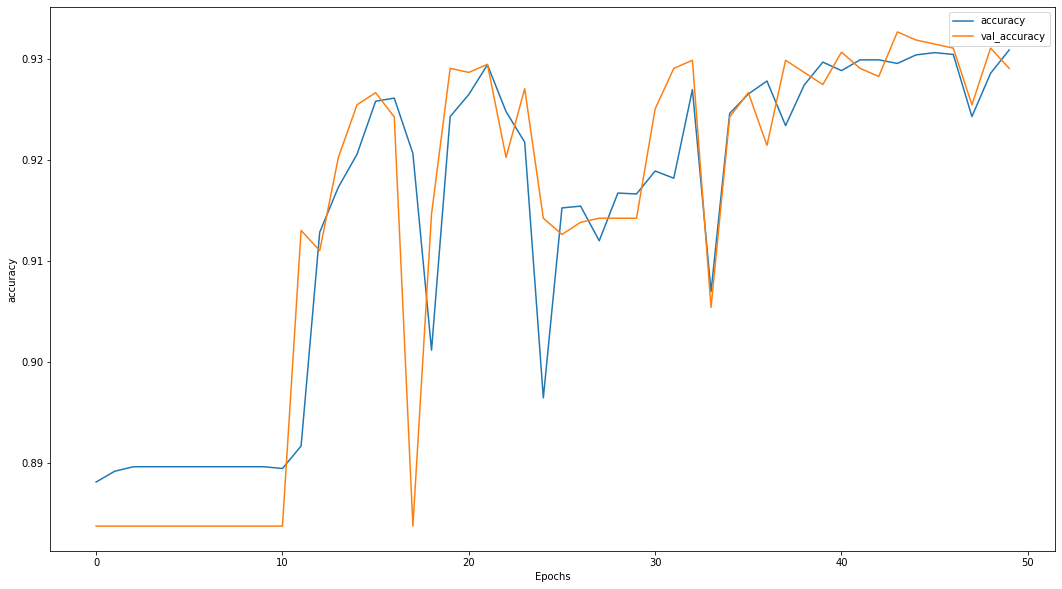

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 10)  # set default figure size

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

    
plot_graphs(lstm_trained, 'accuracy')

# 5. Evaluate on the tes-dataset

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
# Now computing the longest sentence's length to later pad to that length 
#setting the max length to 0
max_len = 0

#create sentence and label lists from train dataset
sentences = test_dataset.sentence.values
labels = test_dataset.label.values

#for every sentence...
for sent in sentences:

    #tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    #update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

#printing the maximum sentence length. 
print('Max sentence length: ', max_len)

Max sentence length:  200


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])


# Convert the lists into numpy arrays.
input_ids = [t.numpy() for t in input_ids]
labels = np.array(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print ('Label:', labels[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  The Pension Convenant seeks to support Pension Funds to implement OECD orientations regarding ESG.nThe two track approach has a general track where all Dutch pension funds are targetted and a second track to undertake case studies and feed into the general track.nnThe
Token IDs: [[  101  1996 11550  9530  8159  4630 11014  2000  2490 11550  5029  2000
  10408  1051  8586  2094 10296  2015  4953  9686  2290  1012 23961  5369
   2048  2650  3921  2038  1037  2236  2650  2073  2035  3803 11550  5029
   2024  4539  3064  1998  1037  2117  2650  2000 16617  2553  2913  1998
   5438  2046  1996  2236  2650  1012  1050  3372  5369   102     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0

In [ ]:
# We must have the input_ids in the right format for the LSTM to read accurately. 
# That is, each sentence must be one array. 
# The current format makes each input_id vector be an array of an array. 

#therefore:
#creating an empty list b
input_id = []

#looping in the first input_ids array
for ids in input_ids: 
  #looping in the final array
  for i in ids:
    #appending to the new list 
    input_id.append(i)

#
document_labels = test_dataset['document_label']

# Creating a test_dataset with the good input_ids format, associating the labels 
test_dataset = pd.DataFrame({'input_ids': input_id,
                             'label' :  labels,
                             'document_label' : document_labels,
                             'sentence' : sentences
                             })

# Splitting the test set into an X and a y respectively 
# Converting the data from dataframes to numpy arrays
X_test, y_test = np.vstack(test_dataset['input_ids'].values), test_dataset['label'].values

In [ ]:
def predict_summary(X, threshold=0.5):
    probabilities = lstm_model.predict(X)
    predictions = [1 if prob >= threshold else 0 for prob in probabilities]
    return predictions

In [ ]:
# Show predictions on the dev set
test_dataset_predict = test_dataset.copy()
test_dataset_predict['prediction'] = predict_summary(X_test)
test_dataset_predict

,input_ids,label,document_label,sentence,prediction
0,"[101, 1996, 11550, 9530, 8159, 4630, 11014, 20...",1,2668,The Pension Convenant seeks to support Pension...,0
1,"[101, 9530, 8159, 4630, 2097, 2147, 2007, 1037...",0,2668,Convenant will work with a Steering Group and ...,0
2,"[101, 2006, 2019, 5020, 3978, 1010, 23060, 701...",0,2668,"On an equal basis, Oxfam Novib also participat...",0
3,"[101, 2027, 8558, 2191, 2019, 2590, 6691, 2000...",0,2668,They thereby make an important contribution to...,0
4,"[101, 3119, 9209, 2920, 2097, 8145, 1998, 3745...",0,2668,trade unions involved will collect and share t...,0
...,...,...,...,...,...
6225,"[101, 1996, 4746, 2573, 2007, 1019, 3164, 5826...",0,2780,The programme works with 5 regional partners (...,0
6226,"[101, 2006, 2140, 29602, 2140, 2022, 3625, 200...",0,2780,ONLwill be responsible for implementation as e...,0
6227,"[101, 2019, 6970, 10354, 8873, 6632, 2618, 382...",0,2780,An interaffiliate agreement has been establish...,0
6228,"[101, 2006, 2140, 29602, 2140, 2022, 2266, 199...",0,2780,ONLwill be member of the Programme Steering Co...,0


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Create a new dataframe which groups the predictions based on their document_label to map the prediction to the original text 
df_summaries = test_dataset_predict.groupby('document_label').agg(list)
#resetting the index
df_summaries = df_summaries.reset_index()

# Now we wish to extract the summaries only 
# Keeping the sentences that were predicted with 1
#creating empty lists
predicted_labels, predicted_sentences, actual_labels, actual_sentences, doc_labels =[],[],[],[],[]

#looping in every line of the df_summaries simultaneously 
for predicted_label, predicted_text, actual_label, doc_label in zip(df_summaries['prediction'], 
                                                                    df_summaries['sentence'], 
                                                                    df_summaries['label'], 
                                                                    df_summaries['document_label']):
    #looping in each item of each line of df_summaries
    for pred_label, pred_sent, act_label in zip(predicted_label, 
                                                              predicted_text, 
                                                              actual_label):
        #setting the condition that only if the item equals 1 in the predicted_labels
        #assing the text, the predicted label, the actual label and the document label to the lists 
        if pred_label == 1:
            predicted_labels.append(pred_label)
            predicted_sentences.append(pred_sent)
            actual_labels.append(act_label)
            doc_labels.append(doc_label)

# Creating a new dataframe with only the predicted sentences kept, against the actual label 
df_summaries = pd.DataFrame({'predicted_label': predicted_labels,
                             'predicted_summary': predicted_sentences,
                             'reference_label' : actual_labels,
                             'document_label': doc_labels})

#grouping by the document label and resetting the index 
df_summaries = df_summaries.groupby('document_label').agg(list).reset_index()

# Adding the actual summaries for each document to the dataframe
# This is critical for the evaluation 

#creataing an empty list 
reference_summaries = []

#looping though the document labels in the df_summaries 
for label in df_summaries['document_label']:
  #looping through both the indexes and the text of the original summaries in the initial dataframe
  for index, summ in zip(df.index, df['summary_clean']):
        #setting the condition that if the index of the actual summary in the original document equals 
        #to the label of the document in the results (i.e. summaries) dataframe 
        #append the summary to the empty list
        if label == index:
            reference_summaries.append(summ)

# Adding the list to the df_summaries dataframe
df_summaries['reference_summary'] = reference_summaries



### 5.3.2. Computing ROUGE scores

In [ ]:
# Computing rouge scores for the results 

#load Huggingface's rouge metric 
metric = load_metric("rouge")

#creating empty lists for the predicted and the actual summaries 
predicted_summaries = []
reference_summaries = []

#looping through both the predicted and the actual summaries 
for doc_pred, doc_label in zip(df_summaries['predicted_summary'], df_summaries['reference_summary']):
    #looping through each sentence within the predicted and the actual summaries  
    for pred_summ, labelled_summ in zip(doc_pred, doc_label):
        #appending these to the empty lists 
        predicted_summaries.append(pred_summ)
        reference_summaries.append(labelled_summ)

#computing and saving the rouge scores in rouge_scores object 
rouge_scores = metric.compute(predictions=predicted_summaries, references=reference_summaries)

#printing the scores 
print(rouge_scores)

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

{'rouge1': AggregateScore(low=Score(precision=0.8704682987311643, recall=0.901638402960894, fmeasure=0.8784944122799918), mid=Score(precision=0.8943366103828883, recall=0.9244551835869859, fmeasure=0.902221355915023), high=Score(precision=0.9208624141781133, recall=0.9471169092455627, fmeasure=0.9273438185073257)), 'rouge2': AggregateScore(low=Score(precision=0.8424241152906513, recall=0.8632615282269592, fmeasure=0.8487276624815204), mid=Score(precision=0.8767926295980395, recall=0.8965399541689477, fmeasure=0.8830686077737154), high=Score(precision=0.9062893168833566, recall=0.9242020888753291, fmeasure=0.912365934125286)), 'rougeL': AggregateScore(low=Score(precision=0.8614275916179409, recall=0.8901395175302159, fmeasure=0.8692109832458799), mid=Score(precision=0.8891694665398677, recall=0.9147215200165602, fmeasure=0.896417287656813), high=Score(precision=0.9183819769378859, recall=0.9393613223416796, fmeasure=0.9244867140731696)), 'rougeLsum': AggregateScore(low=Score(precision=0

# 6. Extract predicted and reference summaries to assess the quality of the predictions

In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][2])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][2])

This is the reference summary: 
['The proposed project aims at upgrading an earth-gravel road linking Middlepits to Bokspits over a distance of 153 km and approximately 4km of village access roads.']
This is the predicted summary: 
['The proposed project aims at upgrading an earth-gravel road linking Middlepits to Bokspits over a distance of 153 km and approximately 4km of village access roads.', 'The proposed project is included in the ongoing Five Year ""National Development Plan 8"" (NDP8) and the Transport Sector Strategy.']


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][5])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][5])

This is the reference summary: 
['The proposed project includes the upgrading and rehabilitation of the existing road between Loboguerrero and the Port ofnBuenaventura']
This is the predicted summary: 
['The proposed project includes the upgrading and rehabilitation of the aforementionednSection II comprising of the existing road between Loboguerrero and the Port ofnBuenaventura.']


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][243])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][243])

This is the reference summary: 
["The development objective of the Natural Gas Connections Project of Egypt is to (i) contribute to the Government of Egypt (GOE)'s program of switching consumption of liquefied petroleum gas (LPG) for natural gas through investment in new connections; and (ii) exploit the scale economies in transportation of natural gas relative to LPG in very densely populated areas, thereby reducing the cost of gas provision."]
This is the predicted summary: 
["The development objective of the Natural Gas Connections Project of Egypt is to (i) contribute to the Government of Egypt (GOE)'s program of switching consumption of liquefied petroleum gas (LPG) for natural gas through investment in new connections; and (ii) exploit the scale economies in transportation of natural gas relative to LPG in very densely populated areas, thereby reducing the cost of gas provision."]


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][103])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][103])

This is the reference summary: 
['The objective of the Enhanced Vocational Education and Training Project for Nepal is to expand the supply of skilled and employable labor by increasing access to quality training programs, and by strengthening the technical and vocational education and training system in Nepal.']
This is the predicted summary: 
['The objective of the Enhanced Vocational Education and Training Project for Nepal is to expand the supply of skilled and employable labor by increasing access to quality training programs, and by strengthening the technical and vocational education and training system in Nepal.']


In [ ]:
print('This is the reference summary: ') 
print(df_summaries['reference_summary'][109])
print('This is the predicted summary: ')
print(df_summaries['predicted_summary'][109])

This is the reference summary: 
['The development objective of the Alliance for Education Quality Project for Nicaragua is to improve: (a) teacher practices for participating teachers in preschool, primary, and secondary education nationwide; and (b) physical learning conditions in targeted schools.']
This is the predicted summary: 
['The development objective of the Alliance for Education Quality Project for Nicaragua is to improve: (a) teacher practices for participating teachers in preschool, primary, and secondary education nationwide; and (b) physical learning conditions in targeted schools.']
